In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space, extract_segments_aligned, autocorr_with_interpolation
from scipy.signal import find_peaks
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plotting standards
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# Figure params
SAVE_FIGURE = True
save_figure_path = "./results/figures/leeching/"
os.makedirs(save_figure_path, exist_ok=True)
fdict = dict(fname=f"", dpi=600, bbox_inches="tight", edgecolor=None)

# 1. Import and Load df_stats

In [2]:
# Old code
#df = pd.read_csv("./results/data/leeching/df.csv")
#results_save_path = "./results/data/leeching/overview-analysis/"
#df # 48-0-mostly swim, 105-10-with stage move, 115-13-from26sec onwards=swim

# New code
masks_dir = "../data/videos/leeching/philodina/seg_masks/"
masks_path_names = sorted([dir for dir in os.listdir(masks_dir) if dir.endswith("masks")])
# Corresponding videos
vid_path = "../data/videos/leeching/philodina/ori_videos/"
vid_filenames = [fn.split("_masks")[0] + ".MP4" for fn in masks_path_names]
vid_props = {k : get_video_properties(vid_path, k) for k in vid_filenames}
df = pd.DataFrame.from_dict(vid_props, orient="index").reset_index()
df.columns = ["filename", "fps", "num_frames", "width", "height"]

# Scale
pixel_per_real_width =  2.127659 #  >> for Dlow
mpp = 0.47 # microns_per_pixel for Dlow

# Save figures
read_in_path = "./results/data/leeching/"
dfs_stats, dfs_points = [], []
for vid_filename in vid_filenames:
    dfs_stats.append(pd.read_csv(os.path.join(read_in_path, vid_filename.split(".MP4")[0] + "_df_stats.csv")))
    dfs_points.append(pd.read_csv(os.path.join(read_in_path, vid_filename.split(".MP4")[0] + "_df_points.csv")))

In [3]:
remove_idx = [0,10]
keep_idx = np.arange(0, len(df))
keep_idx = np.delete(keep_idx, remove_idx); #print("n_keep_idx ", len(keep_idx))
df.loc[13, "num_frames"] = 1500  # exclude swim

fps = 60
total_frames = df.loc[keep_idx, "num_frames"].sum()
rec_durations = np.round(df.loc[keep_idx, "num_frames"].to_numpy() / fps, 2)
total_rec_duration = sum(rec_durations)
mean_rec_duration = np.mean(rec_durations)
std_rec_duration = np.std(rec_durations)
print("n:", len(keep_idx), "total frames:", total_frames, "total rec_duration (sec):", total_rec_duration,
      "mean±std rec_duration (sec):", round(mean_rec_duration,2), "±", round(std_rec_duration,2))

# centroid moves with animal, that is traces elongations and retractions > don't use
#np.nansum(dfs_stats[2]["centroid_dist"]) * mpp
#dfs_stats[2]["centroid_x"].diff(periods=5).dropna()
#tmp = dfs_stats[2]["centroid_y"].diff(periods=50).dropna()

n: 12 total frames: 15883 total rec_duration (sec): 264.72 mean±std rec_duration (sec): 22.06 ± 7.65


# Autocorrelation

[0 1 2 3 4 5 6 7 8]


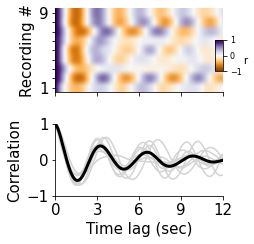

In [4]:
autocorr_idx = [2,3,4,6,7,8,9,10,11]
rec_nframes = df.num_frames.to_numpy()[autocorr_idx]
fwindow = 720
trimmed_acorr = []

for nth, idx in enumerate(autocorr_idx):
    signal = np.array(dfs_stats[idx]["perimeter"])
    signal = signal - np.nanmean(signal)
    trimmed_acorr.append(autocorr_with_interpolation(signal)[rec_nframes[nth]:rec_nframes[nth] + fwindow])

trimmed_acorr = np.array(trimmed_acorr)

fps = 60
tr_time = np.arange(0, fwindow) / fps
rec_yticks = np.arange(0, 9, 1); print(rec_yticks)
rec_ylabels = [" "] * len(rec_yticks); rec_ylabels[0] = 1; rec_ylabels[-1] = 9

# Plotting
ax_params = dict(xlim=(0, fwindow), xticks=(np.arange(0, 12+3, 3)*fps), xticklabels=[],
          ylim=(-.5, len(autocorr_idx)-.5), yticks=(rec_yticks), yticklabels=rec_ylabels, ylabel="Recording #")
ax_params2 = dict(xlim=(0, 12), xticks=(np.arange(0, 12+3, 3)), xlabel="Time lag (sec)", ylim=(-1, 1), yticks=([-1, 0, 1]), ylabel="Correlation")

fig, ax = plt.subplots(2, 1, figsize=(3, 4), gridspec_kw={"height_ratios": [2, 1], "hspace": .015})
imc = ax[0].imshow(trimmed_acorr, aspect=40, cmap="PuOr", vmin=-1, vmax=1); #  
ax[0].set(**ax_params)

ax[1].plot(tr_time, trimmed_acorr.T, lw=1.5, color="lightgray");
ax[1].plot(tr_time, np.mean(trimmed_acorr, axis=0), "-k", lw=3);
ax[1].set(**ax_params2)

# Colorbar
cax = inset_axes(ax[0], width="5%", height="50%", loc="lower right", bbox_to_anchor=(0.1, 0.25, .9, .75),  # adjust position inside ax (x0, y0, width, height)
                 bbox_transform=ax[0].transAxes, borderpad=0)
cbar = fig.colorbar(imc, cax=cax, orientation='vertical', label="r", ticks=[-1, 0, 1])
cbar.set_label("r", rotation=0, fontsize=10)  # Set label fontsize
cbar.ax.tick_params(labelsize=8)

fdict["fname"] = f"{save_figure_path}/perimeter-autocorrelation-n9-recordings.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Trough triggering

In [5]:
fps = 60
wsize = 10

before, after = 20, 181 # 90,90
time_triggered = np.arange(-before, after) / fps
trough_distance = 120 # 120
centroid_distances = []
perimeters = []
n_troughs = []

for nth, df in enumerate(dfs_stats):
    signal = df["perimeter"].to_numpy() * mpp
    signal = signal - np.nanmean(signal)
    troughs, _ = find_peaks(-signal, distance=trough_distance, height=0)  # Adjust distance as needed
    n_troughs.append(len(troughs[:-1]))
    
    # Smooth + Trigger
    smooth_centroid_dist = df["centroid_dist"].rolling(window=wsize).mean() * mpp
    aligned_centroid_dist = extract_segments_aligned(smooth_centroid_dist, troughs[:-1], before=before, after=after)
    aligned_perimeter = extract_segments_aligned(df["perimeter"].to_numpy() *  mpp, troughs[:-1], before=before, after=after)

    # Collect
    centroid_distances.append(aligned_centroid_dist)
    perimeters.append(aligned_perimeter)

print(n_troughs)
# Stack arrays
pstacked = np.vstack(perimeters)
cstacked = np.vstack(centroid_distances)
print(pstacked.shape, cstacked.shape)

# Normalize signals
pmin = np.nanmin(pstacked, axis=1)
pmax = np.nanmax(pstacked, axis=1)
pstacked_norm = (pstacked - pmin[:, np.newaxis]) / (pmax[:, np.newaxis] - pmin[:, np.newaxis])


[8, 2, 4, 9, 7, 7, 4, 4, 5, 7, 10, 4, 4, 5]
(80, 201) (80, 201)


In [6]:
# CLEAN DATA A BIT
remove_indices = []
for n in range(pstacked_norm.shape[0]):
    remove_indices.append(np.any(np.where(pstacked_norm[n, :30] >= .45)[0]))
print(sum(remove_indices), pstacked_norm.shape)

pstacked_norm_ = np.delete(pstacked_norm, remove_indices, axis=0)
print(pstacked_norm_.shape)

3 (80, 201)
(77, 201)


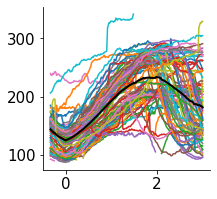

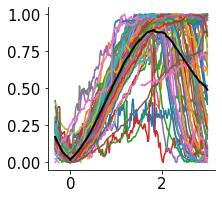

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(time_triggered, pstacked.T);
plt.plot(time_triggered, np.nanmean(pstacked, axis=0), "-k", lw=2);


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(time_triggered, pstacked_norm_.T);
plt.plot(time_triggered, np.nanmean(pstacked_norm_, axis=0), "-k", lw=2);

49
steps 49
others 28


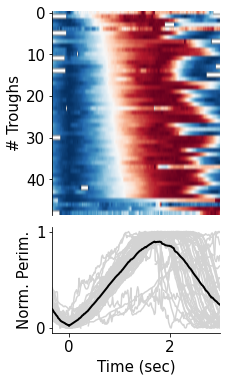

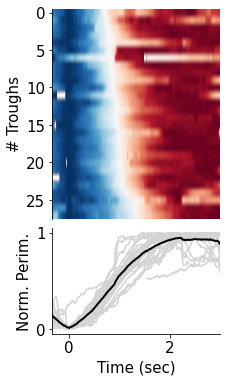

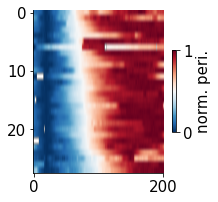

In [8]:
cross_indices = []
for n in range(pstacked_norm_.shape[0]):
    cross_indices.append(np.any(np.where(pstacked_norm_[n, 120:] <= .5)[0]))
print(sum(cross_indices))

step_idx = cross_indices; print("steps", sum(step_idx))
other_idx = ~np.array(cross_indices); print("others", sum(other_idx))
steps = pstacked_norm_[step_idx, :]
others = pstacked_norm_[other_idx, :]

# sort steps by time-to-peak
# max_values = np.nanmax(steps, axis=1)
# mask = steps == max_values[:, np.newaxis]
# time_to_max = np.argmax(mask, axis=1)
sort_idx = np.argmax(steps >= 0.5, axis=1)
step_sort_idx = np.argsort(sort_idx)
sort_idx = np.argmax(others >= 0.5, axis=1)
other_sort_idx = np.argsort(sort_idx)
#step_sort_idx = np.argsort(time_to_max)
# sort other by time-to-peak
# max_values = np.nanmax(others, axis=1)
# mask = others == max_values[:, np.newaxis]
# time_to_max = np.argmax(mask, axis=1)
# other_sort_idx = np.argsort(time_to_max)

fig, ax = plt.subplots(2, 1, figsize=(3, 6), gridspec_kw={"height_ratios": [2, 1], "hspace": .05})
ax[0].imshow(steps[step_sort_idx, :], cmap="RdBu_r", aspect=5, vmin=0, vmax=1)
ax[1].plot(time_triggered, steps.T, "-", lw=1.5, color="lightgray");
ax[1].plot(time_triggered, np.nanmean(steps, axis=0), "-k", lw=2);

ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.set_visible(False); ax[1].set_xlim(time_triggered[0], time_triggered[-1])
ax[0].set_ylabel("# Troughs"); ax[1].set(ylabel="Norm. Perim.", xlabel="Time (sec)", yticks=(0,1))

fig.savefig(f"{save_figure_path}/pooled-steps.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

fig, ax = plt.subplots(2, 1, figsize=(3, 6), gridspec_kw={"height_ratios": [2, 1], "hspace": .05})
ax[0].imshow(others[other_sort_idx, :], cmap="RdBu_r", aspect=9, vmin=0, vmax=1)
ax[1].plot(time_triggered, others.T, "-", lw=1.5, color="lightgray");
ax[1].plot(time_triggered, np.nanmean(others, axis=0), "-k", lw=2);

ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.set_visible(False); ax[1].set_xlim(time_triggered[0], time_triggered[-1])
ax[0].set_ylabel("# Troughs"); ax[1].set(ylabel="Norm. Perim.", xlabel="Time (sec)", yticks=(0,1))
fig.savefig(f"{save_figure_path}/pooled-others.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

fig2, ax = plt.subplots(1, 1, figsize=(3, 3))
cax = ax.imshow(others[other_sort_idx, :], cmap="RdBu_r", aspect=9, vmin=0, vmax=1);
fig2.colorbar(cax, shrink=.5, location="right", ticks=[0, 1], label="norm. peri.")
fig2.savefig(f"{save_figure_path}/steps_colorbar.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None


# Back and Front
- would have to determine this for individual recordings

n_back  1014 n_front  1014
n_back  811 n_front  811
n_back  2032 n_front  2032
n_back  2154 n_front  2154
n_back  1232 n_front  1232
n_back  776 n_front  776
n_back  756 n_front  756
n_back  1323 n_front  1323
n_back  1648 n_front  1648
n_back  897 n_front  897
n_back  1476 n_front  1476
n_back  1500 n_front  1500
329.52182027800814 274.4444273018414


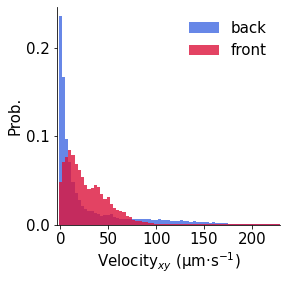

In [9]:
sorted_back_front = {"back" :[], "front": []}
SHOW_FIGURE = False
for idx in keep_idx:
    if idx == 13:
        df_ = dfs_points[idx][:1500]
    else:
        df_ = dfs_points[idx]

    wsize=20
    back = np.sqrt(df_["top_x"].diff().rolling(window=wsize).mean() ** 2 + df_["top_y"].diff().rolling(window=wsize).mean() ** 2)
    front = np.sqrt(df_["bottom_x"].diff().rolling(window=wsize).mean() ** 2 + df_["bottom_y"].diff().rolling(window=wsize).mean() ** 2)
    
    back_clean = np.where(back <= 12, back, np.nan)
    front_clean = np.where(front <= 12, front, np.nan)
    
    avg_top_back = np.nanmean(back_clean[np.argsort(back_clean)[-100:]])
    avg_top_front = np.nanmean(front_clean[np.argsort(front_clean)[-100:]])
    
    # Sorting into back vs front
    if avg_top_back > avg_top_front:
        sorted_back_front["back"].append(back_clean)
        sorted_back_front["front"].append(front_clean)
    else:
        sorted_back_front["back"].append(front_clean)
        sorted_back_front["front"].append(back_clean)
    
    print("n_back ", len(sorted_back_front["back"][-1]), "n_front ", len(sorted_back_front["front"][-1]))
    if SHOW_FIGURE:
        fig, ax = plt.subplots(1, 2, figsize=(12, 1.5))#, gridspec_kw={"height_ratios": [2, 1], "hspace": .025})
        ax[0].plot(df_["top_x"], df_["top_y"], ".g")
        ax[0].plot(df_["bottom_x"], df_["bottom_y"], ".m")
        ax[0].invert_yaxis()
        
        ax[1].plot(sorted_back_front["back"][-1], "-b")            #ax[1].axhline(avg_top_back, color="r", linestyle=":")
        ax[1].plot(sorted_back_front["front"][-1], "-r")            #ax[1].axhline(avg_top_front, color="b", linestyle=":")

        ax[1].set(ylim=(0,12))
        fig.suptitle(f"{vid_filenames[idx]}")
# can determine back by large amplitude displacement (at step time)

# Accumulate values
backs_values = []
fronts_values = []
for lb, lf in zip(sorted_back_front["back"], sorted_back_front["front"]):
    backs_values.extend(lb * mpp * fps)
    fronts_values.extend(lf * mpp * fps)

print(np.nanmax(backs_values), np.nanmax(fronts_values))
xmax = max(np.nanmax(backs_values), np.nanmax(fronts_values))
bins = np.linspace(0, xmax, 100)
#print(bins)
count_back, bins_ = np.histogram(backs_values, bins=bins)
count_front, bins_ = np.histogram(fronts_values, bins=bins)
yb = count_back / sum(count_back)
yf = count_front / sum(count_front)
bins = bins[:-1]
dbins = np.diff(bins)[-1]
ylimit = np.max([yb, yf])

# Plotting
ax_params = dict(ylim=(0,ylimit+.01), xlim=(-dbins,xmax-100), xticks=np.arange(0, xmax-100, 50), yticks=[.0, .1, .2], ylabel="Prob.", xlabel="Velocity$_x$$_y$ (µm·s$^{-1}$)")

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(bins, yb, color="royalblue", width=dbins, alpha=.8, label="back");
ax.bar(bins, yf, color="crimson", width=dbins, alpha=.8, label="front");
ax.set(**ax_params)
ax.legend(frameon=False)

fdict["fname"] = f"{save_figure_path}/front-back-displacement_pooled_across-time.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Back-Front Triggerng

In [10]:
before, after = 90, 90
time_triggered = np.arange(-before, after) / fps

aligned_backs, aligned_fronts = [],[]
for nth, idx in enumerate(keep_idx):
    if idx == 13:
        df_ = dfs_points[idx][:1500]
        signal = dfs_stats[idx]["perimeter"][:1500].to_numpy() * mpp
    else:
        df_ = dfs_points[idx]
        signal = dfs_stats[idx]["perimeter"].to_numpy() * mpp

    signal = signal - np.nanmean(signal)
    troughs, _ = find_peaks(-signal, distance=trough_distance, height=0)
    
    aligned_front = extract_segments_aligned(sorted_back_front["front"][nth] * mpp, troughs[1:-1], before=before, after=after)
    aligned_back = extract_segments_aligned(sorted_back_front["back"][nth] * mpp, troughs[1:-1], before=before, after=after)
    
    # Collect
    aligned_backs.append(aligned_back)
    aligned_fronts.append(aligned_front)
    
# Stack arrays
backs_stacked = np.vstack(aligned_backs)
fronts_stacked = np.vstack(aligned_fronts)

remove_indices_b = []
for n in range(backs_stacked.shape[0]):
    remove_indices_b.append(sum(np.isnan(backs_stacked[n,:]))>50)
print(sum(remove_indices_b), remove_indices_b)

remove_indices_f = []
for n in range(fronts_stacked.shape[0]):
    remove_indices_f.append(sum(np.isnan(fronts_stacked[n,:]))>50)
print(sum(remove_indices_f), remove_indices_f)

backs_stacked = np.delete(backs_stacked, remove_indices_b, axis=0)
fronts_stacked = np.delete(fronts_stacked, remove_indices_f, axis=0)

back_max_vals_before = np.nanmax(backs_stacked[:, 30:90], axis=1)
back_max_vals_after = np.nanmax(backs_stacked[:, 90:150], axis=1)
front_max_vals_before = np.nanmax(fronts_stacked[:, 30:90], axis=1)
front_max_vals_after = np.nanmax(fronts_stacked[:, 90:150], axis=1)
front_max_vals_before
#backs_stacked = np.delete(backs_stacked, remove_indices, axis=0)
#fronts_stacked = np.delete(fronts_stacked, remove_indices, axis=0)


0 [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
0 [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


array([0.55594746, 0.67163228, 0.78342338, 0.82216005, 0.27301391,
       0.45943864, 0.62640616, 1.84248956, 0.77922403, 0.75425588,
       0.90366062, 0.92469801, 0.34204777, 0.45144343, 0.35996552,
       0.34740944, 0.43994162, 0.48425479, 0.33908007, 0.52700825,
       3.45192246, 3.80210165, 3.64642558, 1.43560051, 0.5090583 ,
       0.50868779, 0.50183452, 0.51785436, 0.47437389, 0.5283857 ,
       1.45201285, 1.04356552, 0.54917594, 0.62277047, 0.46809003,
       0.50403918, 0.5828777 , 0.63714015, 0.51000071, 0.54146503,
       0.47791701, 0.65794527, 0.63487309, 0.3447109 , 0.38126204,
       0.41181215, 0.34829032, 0.39584461, 2.21292183, 1.21694509])

In [11]:
bs, fs = [], []
for b, f in zip(aligned_backs, aligned_fronts):
    bs.append(np.nanmean(b, axis=0))
    fs.append(np.nanmean(f, axis=0))

print(np.vstack(fs).max(),np.vstack(bs).max(), backs_stacked.shape)

1.7563659513880374 2.8836844250998226 (50, 180)


In [12]:
backs_stacked.shape
argmax_indices = np.argmax(backs_stacked, axis=1)
argmax_indices#.shape
sorted_idx = np.argsort(argmax_indices)

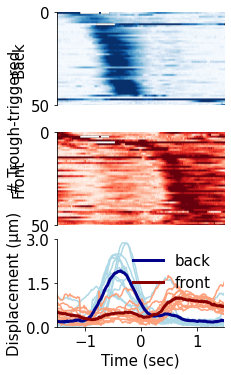

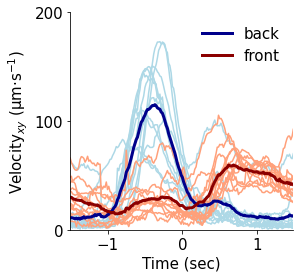

In [13]:
argmax_indices = np.argmax(backs_stacked, axis=1)
bsorted = np.argsort(argmax_indices)[::-1]
argmax_indices = np.argmax(fronts_stacked, axis=1)
fsorted = np.argsort(argmax_indices)[::-1]

fig, ax = plt.subplots(3, 1, figsize=(3, 6), gridspec_kw={"height_ratios": [2, 2, 1.5], "hspace": .025})

ax[0].imshow(backs_stacked[bsorted, :], vmin=0, vmax=2, cmap="Blues", aspect=2);
ax[1].imshow(fronts_stacked[fsorted, :], vmin=0, vmax=1, cmap="Reds", aspect=2);

ax[0].spines['bottom'].set_visible(False); ax[0].xaxis.set_visible(False);
ax[0].set(ylabel="Back", ylim=(0,50), yticks=(0, 50), yticklabels=["50", "0"])
ax[1].spines['bottom'].set_visible(False); ax[1].xaxis.set_visible(False);
ax[1].set(ylabel="Front", ylim=(0,50), yticks=(0, 50), yticklabels=["50", "0"])


ax[2].plot(time_triggered, np.vstack(bs).T, lw=1.5, color="lightblue");
ax[2].plot(time_triggered, np.vstack(fs).T, lw=1.5, color="lightsalmon");
ax[2].plot(time_triggered, np.nanmean(np.vstack(bs), axis=0), lw=3, color="darkblue", label="back");
ax[2].plot(time_triggered, np.nanmean(np.vstack(fs), axis=0), lw=3, color="darkred", label="front");

fig.text(-0.10, .6, '# Trough-triggered', va='center', rotation='vertical')

ax[2].set_xlim(time_triggered[0], time_triggered[-1])
ax[2].set(ylabel="Displacement (µm)", xlabel="Time (sec)", ylim=(0,3), yticks=(0,1.5,3))
ax[2].legend(frameon=False)

fdict["fname"] = f"{save_figure_path}/trough-triggered-front-back-displacement.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Plotting
ax_params = dict(xlim=(time_triggered[0], time_triggered[-1]), xticks=[-1,0,1], ylabel="Velocity$_x$$_y$ (µm·s$^{-1}$)", xlabel="Time (sec)", ylim=(0,200), yticks=(0,100,200))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(time_triggered, np.vstack(bs).T * fps, lw=1.5, color="lightblue");
ax.plot(time_triggered, np.vstack(fs).T * fps, lw=1.5, color="lightsalmon");
ax.plot(time_triggered, np.nanmean(np.vstack(bs), axis=0) * fps, lw=3, color="darkblue", label="back");
ax.plot(time_triggered, np.nanmean(np.vstack(fs), axis=0) * fps, lw=3, color="darkred", label="front");

ax.set(**ax_params)
ax.legend(frameon=False)

fdict["fname"] = f"{save_figure_path}/average-trough-triggered-front-back-velocity.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

array([22, 15, 20, 11, 13, 21, 27, 10, 18, 16,  5,  7,  6, 17,  9, 24, 12,
       26,  4, 19,  2, 25, 14,  8, 23,  3,  1,  0])

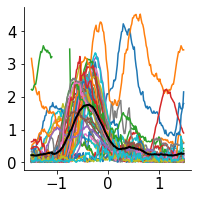

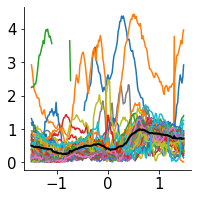

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(time_triggered, backs_stacked.T);
plt.plot(time_triggered, np.nanmean(backs_stacked, axis=0), "-k", lw=2);

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(time_triggered, fronts_stacked.T);
plt.plot(time_triggered, np.nanmean(fronts_stacked, axis=0), "-k", lw=2);

other_sort_idx

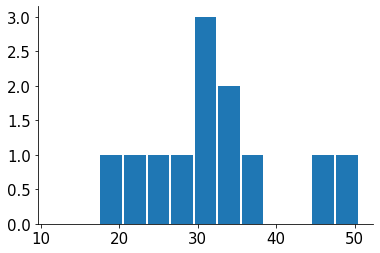

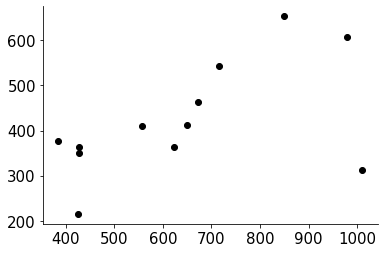

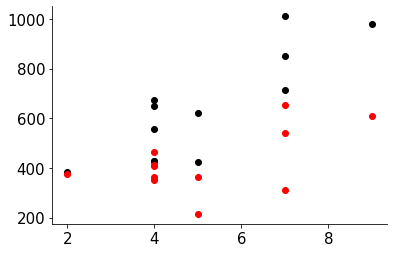

In [15]:
displacments = []
for idx in keep_idx:
    if idx == 13:
        df_ = dfs_stats[idx][:1500]
    else:
        df_ = dfs_stats[idx]
        
    cx = df_["centroid_x"].dropna().to_numpy()
    cy = df_["centroid_y"].dropna().to_numpy()
    dx = cx[0] - cx[-1]
    dy = cy[0] - cy[-1]
    total_displacement = np.sqrt(dx ** 2 + dy ** 2) * mpp
    displacments.append(total_displacement)

displacement_per_second = [dis / dur for dis, dur in zip(displacments, rec_durations)]

back_vals = []
for nth in range(len(sorted_back_front["back"])):
    back_vals.append(np.nansum(sorted_back_front["back"][nth]) * mpp)

back_per_second = [b / dur for b, dur in zip(back_vals, rec_durations)]

step = 3
bins = np.arange(10, 50, step)
count, bins_ = np.histogram(back_per_second, bins=bins)#count, bins_ = np.histogram(displacement_per_second, bins=bins)
plt.figure()
plt.bar(bins_[1:], count, width=step-.25)

plt.figure()
plt.plot(back_vals, displacments, "ok")
back_per_second

n_troughs = np.array(n_troughs)

plt.figure()
plt.plot(n_troughs[keep_idx], back_vals, "ok")
plt.plot(n_troughs[keep_idx], displacments, "or")
# for nth, idx in enumerate(keep_idx):
#     n_troughs[idx]